In [54]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import torch

import jax
import jax.numpy as jnp
from jax import random, jit
from jax.random import PRNGKey

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data

import nn_pytorch

In [70]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = np.array(jnp.squeeze(y_noisy_ho))
t_ho = np.array(jnp.squeeze(t_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

In [86]:
print("y0 dtype:", y0.dtype, "t dtype:", t.dtype)
print("y0 device:", y0.device, "t device:", t.device)


y0 dtype: torch.float32 t dtype: torch.float32
y0 device: cpu t device: cpu


In [85]:
importlib.reload(nn_pytorch)
NeuralODE = nn_pytorch.NeuralODE

layer_widths = [2, 40, 2]
learning_rate = 1e-3

y_pred_results = {}

t = torch.tensor(np.array(t_ho), dtype=torch.float32)
y_noisy = torch.tensor(np.array(y_noisy_ho), dtype=torch.float32)
y0 = torch.tensor(initial_state, dtype=torch.float32)

ode_model = NeuralODE(layer_widths, learning_rate)

for k in [int(len(t)*0.1), len(t)]:
    ode_model.train_model(t[:k], y_noisy[:k], y0, num_epochs = 100)

# generate predictions
y_pred = ode_model.predict(y0, t)

Epoch 0, Loss: 0.20520147681236267
Epoch 0, Loss: 4.8911919593811035


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x200 and 2x40)

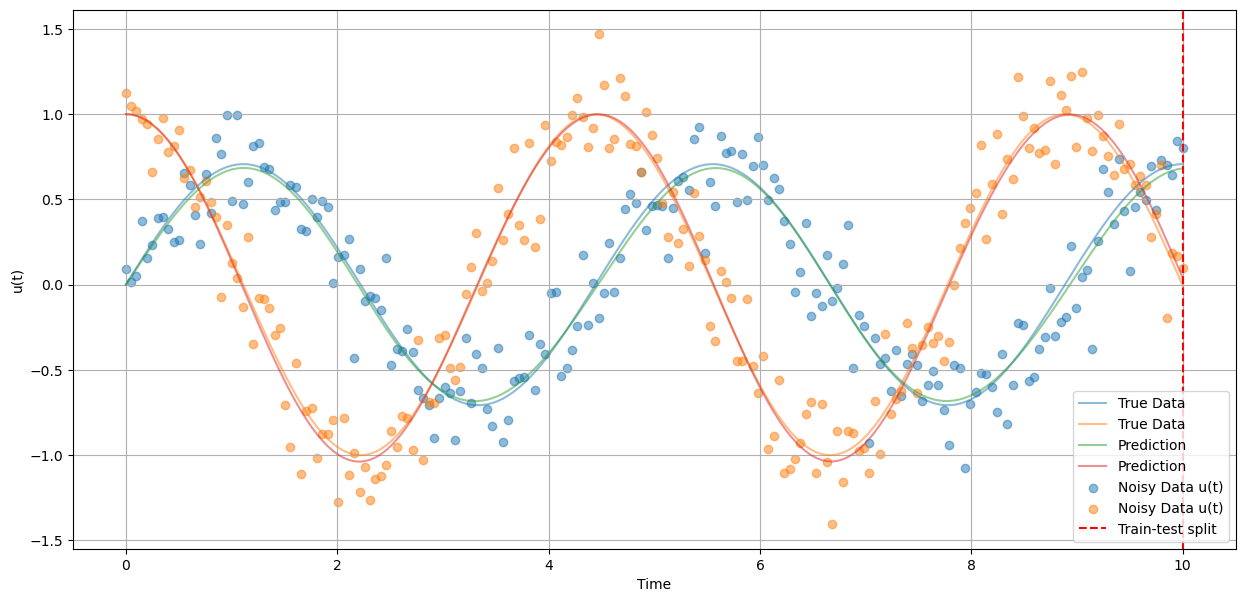

In [46]:
y_pred = neural_ode_py(trained_model, y0, t)

plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_ho, label='True Data', alpha = 0.5)
plt.plot(t_ho, y_pred, label='Prediction', alpha = 0.5)
plt.scatter(t_ho, y_noisy[:,0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_ho, y_noisy[:,1], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## Van Der Pol Oscillator

In [43]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)